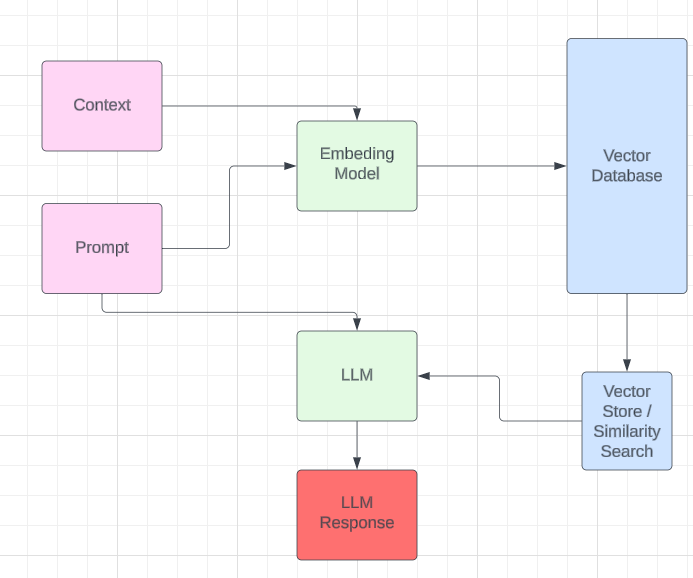

In [1]:
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter, PDFFileLoader
from aimakerspace.vectordatabase import VectorDatabase
import asyncio

In [17]:
import nest_asyncio
nest_asyncio.apply()

In [18]:
text_loader = PDFFileLoader("data/sample_policy_and_procedures_manual.pdf")
documents = text_loader.load_documents()
len(documents)

67

In [19]:
text_splitter = CharacterTextSplitter()
split_documents = text_splitter.split_texts(documents)
len(split_documents)

189

In [20]:

from dotenv import load_dotenv
load_dotenv()

True

In [21]:
import os
import openai
openai.api_key = os.environ["OPENAI_API_KEY"]

In [22]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

In [23]:
vector_db.search_by_text("What holidays does the company recognize", k=3)

[('ses, domestic partners and siblings.  \n \nBereavement leave for death of any person other than immediate family must be approved \nby your immediate supervisor and the department head. Absence for such a death is limited \nto        (     ) days and will be unpaid.  \n \nHolidays  \n      CDC recognizes the following paid holidays:  \n \n1. New Year’s Day  6. Labor Day  \n2. Martin Luther King, Jr. Day  7. Columbus Day  \n3. President’s Day  8. Veteran’s Day  \n4. Memorial Day  9. Thanksgiving  \n5. Independence Day  10. Christmas Day  \n \n \nOn National Election Day       CDC allows all staff up to       hours time off to vote, or time \noff as required by local law  An employee must notify his/her supervisor in advance when time \noff to vote is t o be used.  \n \nLeave of Absence (non FMLA)  \nEmployees are eligible to apply for an unpaid leave of absence if they have been a regular \nemployee for at least one year and scheduled to work       hours or more per week. \nEmployees

In [24]:
import wandb
wandb_key = os.environ["WANDB_API_KEY"]
os.environ["WANDB_NOTEBOOK_NAME"] = "Python RAQA Example.ipynb"
wandb.init(project="Visibility Example")

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [25]:
from aimakerspace.openai_utils.prompts import (
    UserRolePrompt,
    SystemRolePrompt,
    AssistantRolePrompt,
)

from aimakerspace.openai_utils.chatmodel import ChatOpenAI

chat_openai = ChatOpenAI()

RAQA_PROMPT_TEMPLATE = """ \
Use the provided context to answer the user's query. 

You may not answer the user's query unless there is specific context in the following text.

If you do not know the answer, or cannot answer, please respond with "I don't know".
"""

raqa_prompt = SystemRolePrompt(RAQA_PROMPT_TEMPLATE)

USER_PROMPT_TEMPLATE = """ \
Context:
{context}

User Query:
{user_query}
"""
user_prompt = UserRolePrompt(USER_PROMPT_TEMPLATE)


In [26]:
import datetime
from wandb.sdk.data_types.trace_tree import Trace

class RetrievalAugmentedQAPipeline:
    def __init__(self, llm: ChatOpenAI(), vector_db_retriever: VectorDatabase, wandb_project = None) -> None:
        self.llm = llm
        self.vector_db_retriever = vector_db_retriever
        self.wandb_project = wandb_project

    def run_pipeline(self, user_query: str) -> str:
        context_list = self.vector_db_retriever.search_by_text(user_query, k=4)
        
        context_prompt = ""
        for context in context_list:
            context_prompt += context[0] + "\n"

        formatted_system_prompt = raqa_prompt.create_message()

        formatted_user_prompt = user_prompt.create_message(user_query=user_query, context=context_prompt)

        
        start_time = datetime.datetime.now().timestamp() * 1000

        try:
            openai_response = self.llm.run([formatted_system_prompt, formatted_user_prompt], text_only=False)
            end_time = datetime.datetime.now().timestamp() * 1000
            status = "success"
            status_message = (None, )
            response_text = openai_response.choices[0].message.content
            token_usage = dict(openai_response.usage)
            model = openai_response.model

        except Exception as e:
            end_time = datetime.datetime.now().timestamp() * 1000
            status = "error"
            status_message = str(e)
            response_text = ""
            token_usage = {}
            model = ""

        if self.wandb_project:
            root_span = Trace(
                name="root_span",
                kind="llm",
                status_code=status,
                status_message=status_message,
                start_time_ms=start_time,
                end_time_ms=end_time,
                metadata={
                    "token_usage" : token_usage,
                    "model_name" : model
                },
                inputs= {"system_prompt" : formatted_system_prompt, "user_prompt" : formatted_user_prompt},
                outputs= {"response" : response_text}
            )

            root_span.log(name="openai_trace")
        
        return response_text if response_text else "We ran into an error. Please try again later. Full Error Message: " + status_message

In [27]:
retrieval_augmented_qa_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai,
    wandb_project="LLM Visibility Example"
)

In [28]:
print(retrieval_augmented_qa_pipeline.run_pipeline("What holidays does the company recognize?"))

The company recognizes the following paid holidays:

1. New Year’s Day
2. Martin Luther King, Jr. Day
3. President’s Day
4. Memorial Day
5. Independence Day
6. Labor Day
7. Columbus Day
8. Veteran’s Day
9. Thanksgiving
10. Christmas Day


In [29]:
print(retrieval_augmented_qa_pipeline.run_pipeline("What is the company's policy on vacation time?"))

The company's policy on vacation time includes details such as employees being able to accumulate vacation days from the start of employment at a specific rate, full-time employees being able to take vacation time subject to approval after six months of service, the accrual rate increasing after the first year, and allowing for a carry-over of a specific number of vacation days from one calendar year to the next. Additionally, vacation time can be taken in full or half-day increments, approval must be obtained from the immediate supervisor, and vacation requests should be submitted in advance.


In [30]:
print(retrieval_augmented_qa_pipeline.run_pipeline("What is the companys dress code?"))

I don't know.


In [16]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Navigate to the Weights and Biases "run" link to see how your LLM is performing!

```
View run at YOUR LINK HERE
```